# Breakthrough curve for a geothermal doublet
## New analytical solution combining Schulz (1987) and Charbeneau (2000)

This notebook combines two analytical solutions to model heat transport in a confined aquifer without regional groundwater flow. The first solution is adapted from Charbeneau (2000) and models heat transport within the aquifer itself, assuming no exchange between the aquifer and the surrounding aquitards. The second solution, from Schulz (1987), describes heat exchange between the aquifer and adjacent aquitard layers.

## Conceptual model

By combining these two models, this approach captures both the advective-dispersive transport of heat inside the aquifer and the conductive heat exchange with the aquitard. The assumption of no regional groundwater flow simplifies the system, allowing the breakthrough curve to be expressed with a simple analytical formula, avoiding the need for numerical integration.

The combination leverages the equivalence of the governing equations for tracer transport and thermal transport in porous media. The model calculates the temperature distribution in the aquifer and the heat exchange with the aquitards, leading to a comprehensive yet computationally efficient analytical solution for heat transport and thermal breakthrough.

## Model application

This model is particularly useful for geothermal and hydrological studies where regional flow is negligible and accurate estimation of thermal breakthrough times is needed. The analytical nature enables quick evaluation and benchmarking for more complex numerical models.

## References

Schulz, R. (1987). Analytical model calculations for heat exchange in a confined aquifer. Journal of Geophysics, 61, 12–20.

Charbeneau, R. J. (2000). Groundwater Hydraulics and Pollutant Transport. Prentice Hall, Upper Saddle River.

In [1]:
import numpy as np

## Define parameters

# Time period
# Duration of the observation period (years)
tmax = 100

# Aquifer
M = 30             # Thickness of the aquifer (m)
phi = 0.4          # Porosity of the aquifer
rho_S = 1900       # Density of the solid matrix (kg/m³)
c_S = 850          # Heat capacity of the solid matrix (J/kg/K)
lambda_S = 3.0     # Thermal conductivity (W/m/K)

kf = 1e-12 * 1000 * 9.81 / 1e-3  # Hydraulic conductivity (m/s)

# Fluid
rho_F = 1500       # Fluid density (kg/m³)
c_F = 4200         # Fluid heat capacity (J/kg/K)

# Doublet
# Half the distance between injection and extraction wells (m)
a = 450
# Injection rate = extraction rate (m³/s)
Q = 0.03

# Groundwater
# Groundwater flow velocity. Must be zero here, otherwise the analytical solution by Charbeneau is not valid.
v0 = 0.0

# Direction of groundwater flow (radians)
alpha = np.pi/2

# Constants
a2s = 365*24*3600   # Conversion from seconds to years

# Calculate breakthrough time
rho_A_c_A = phi * rho_F * c_F + (1 - phi) * rho_S * c_S
G = rho_A_c_A / (rho_F * c_F)
tb = G * 4 * np.pi * M * a * a / (3 * Q) / a2s
tmax = 3*tb/G # Time period for streamline integration

# Vertical heat transfer velocity
vz = 2 * lambda_S / M / rho_A_c_A

print(f"The breakthrough time is {tb:.2f} years.")
print(f"Expected pressure difference in the wells for undisturbed groundwater flow {2*a*v0/kf:.2f} meters")

t = tmax*a2s
L = np.sqrt(2*t*lambda_S/rho_A_c_A)
print(f"The radius of influence in the aquitard is {L:.2f} m")

The breakthrough time is 14.90 years.
Expected pressure difference in the wells for undisturbed groundwater flow 0.00 meters
The radius of influence in the aquitard is 66.15 m


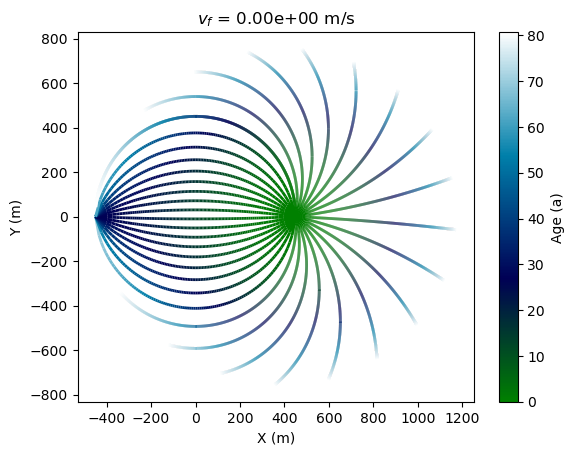

In [2]:
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from cgplot import plot_with_color_gradient, finalize_plot
from numba import jit, njit

# Calculate velocity field components
def velocity_field(t, pos):
    """
    Returns the velocity field at a given position for the doublet system.
    Parameters:
        t (float): Time (not used, for ODE compatibility)
        pos (array): Position [x, y]
    Returns:
        list: [-U, -V] velocity components
    """
    x, y = pos
    A = (x + a)**2 + y**2
    B = (x - a)**2 + y**2
    U = v0*np.cos(alpha) + Q/(2*np.pi*M)*((x+a)/A - (x-a)/B)
    V = v0*np.sin(alpha) + Q/(2*np.pi*M)*(y/A - y/B)
    return [-U, -V]

# Define event to stop integration when the point is closer than 0.1 m to (-a, 0)
def close_to_point(t, pos):
    """
    Event function to stop integration when the trajectory is close to the extraction well.
    Parameters:
        t (float): Time
        pos (array): Position [x, y]
    Returns:
        float: Distance to extraction well minus threshold
    """
    x, y = pos
    distance = np.sqrt((x + a)**2 + y**2)
    return distance - 0.1

close_to_point.terminal = True
close_to_point.direction = 0

# Numerical integration using 4th order Runge-Kutta method
def integration(x_start, y_start, t_span, dt, N=100):
    """
    Integrate the streamline from a starting point using the velocity field.
    Parameters:
        x_start (float): Starting x position
        y_start (float): Starting y position
        t_span (tuple): (start_time, end_time)
        dt (float): Time step
        N (int): Number of output points
    Returns:
        tuple: (t, y, solution) where t is time, y is trajectory, solution is ODE result
    """
    t_eval = np.arange(t_span[0], t_span[1], dt)
    initial_conditions = [x_start, y_start]
    solution = solve_ivp(
        velocity_field,
        t_span,
        initial_conditions,
        method='LSODA',
        t_eval=t_eval,
        rtol=1e-5,
        atol=1e-8,
        max_step=30*24*3600,
        events=close_to_point,
        dense_output=True,
        first_step=0.1
    )
    if solution.status == 1:
        if solution.t_events[0].size > 0:
            t = list()
            y = list()
            tmax = solution.t_events[0][0]
            for a in range(N+1):
                tn = a/N * tmax
                t.append(tn)
                y.append(solution.sol(tn))
            t = np.array(t).transpose()
            y = np.array(y).transpose()
        else:
            print("An error occurred?!?")
            t = solution.t
            y = solution.y
    else:
        t = solution.t
        y = solution.y
    return np.array(t), np.array(y), solution

# Starting point and parameters
beta = 0 #np.pi/2
delta = 1
x_start, y_start = a + delta*np.sin(beta), 0.0 + delta*np.cos(beta)
t_span = (0, tmax*a2s)  # Start and end time
dt = 0.05 * a2s

doplot = True

if doplot:
    plt.figure()
    plt.title(f"$v_f$ = {v0:.2e} m/s")

I = list()
betas = np.linspace(0, 2*np.pi, 36)

def calc_streamline(beta, doplot=doplot):
    """
    Calculate a streamline for a given angle beta.
    Parameters:
        beta (float): Angle for streamline start
        doplot (bool): Whether to plot the streamline
    Returns:
        float: Residence time (years)
    """
    x_start, y_start = a + delta*np.sin(beta), 0.0 + delta*np.cos(beta)
    t, trajectory, solution = integration(x_start, y_start, t_span, dt)
    if doplot:
        plot_with_color_gradient(trajectory[0][:], trajectory[1][:], t/a2s, zmin=0, zmax=tmax, cmap='ocean', linewidth=2)
    return t[-1]/a2s

for beta in betas:
    tau = calc_streamline(beta)
    I.append(tau)

if doplot:
    finalize_plot()

C:\Users\jante\AppData\Local\Temp\ipykernel_9292\2550753479.py:27: RuntimeWarning: invalid value encountered in divide
  tf = 4 *np.pi * phi * M * a * a / Q * (1 - np.pi * F / np.tan(np.pi * F)) / (np.sin(np.pi * F) ** 2) / a2s


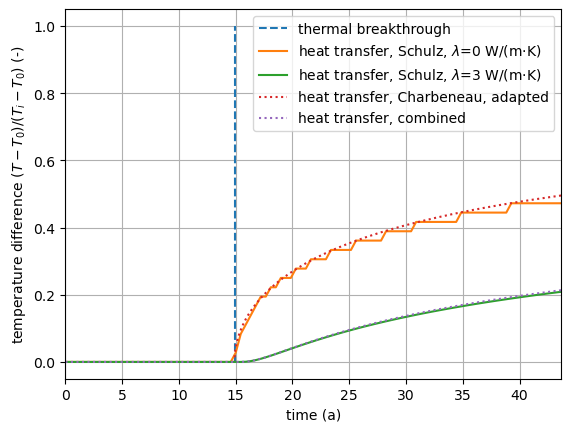

In [3]:
from scipy.special import erfc

time = np.linspace(0, tmax*G-1, 100) # The calculation is only valid for the period tmax*G-1. For a longer period, change parameter tmax.
plt.plot([tb, tb], [0, 1], '--', label="thermal breakthrough")

for lambda_ in [1e-8, lambda_S]:

    H = np.sqrt(lambda_*rho_S*c_S) / (M * rho_F * c_F)
    T = np.zeros_like(time)

    for tau in I:

        U = np.heaviside(time-G*tau, 1)
        ind = U > 0
        abc = erfc(H*tau*np.sqrt(a2s)/np.sqrt(time[ind]-G*tau))

        T[ind] = T[ind] + U[ind]*abc

    plt.plot(time, T/len(I), label=f"heat transfer, Schulz, $\lambda$={lambda_:.0f} W/(m$\cdot$K)")


# Formula from R.J. Charbeneau: Groundwater Hydraulics and Pollutant Transport, 2000
# p. 318 - Formula 6.4.11 -> Adapted for heat transfer

phi1 = np.linspace(0, np.pi, 360)
F = 1 - phi1/np.pi
tf = 4 *np.pi * phi * M * a * a / Q * (1 - np.pi * F / np.tan(np.pi * F)) / (np.sin(np.pi * F) ** 2) / a2s
tau2 = G*tf/phi

plt.plot(tau2, F, ':', label="heat transfer, Charbeneau, adapted")

# Adapted solution for heat transfer combined with the Schulz's solution
# Note: regional groundwater flow velocity needs to be negligible compared to well-induced flow velocity.
T = np.zeros_like(time)
for tau in tau2:

    U = np.heaviside(time-tau, 1)
    ind = U > 0
    abc = erfc(H*tau/G*np.sqrt(a2s)/np.sqrt(time[ind]-tau))

    T[ind] = T[ind] + U[ind]*abc


plt.plot(time, T/len(tau2), ':', label="heat transfer, combined")

plt.grid()
plt.xlim((0, tmax*G-1))
plt.xlabel("time (a)")
plt.ylabel("temperature difference $(T - T_0) / (T_i - T_0)$ (-)")
plt.legend()
plt.show()

The figure compares the three solutions, showing good agreement between them.

The steps observed in Schulz’s solution can be explained by the fact that advective arrival times are summed over a finite number of streamlines. Increasing the number of streamlines would result in a smoother curve, but this would also increase the computation time.